In [1]:
import numpy as np
import pandas as pd
from music21 import converter, corpus, instrument, midi, note, chord, pitch

In [2]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]

    return midi.translate.midiFileToStream(mf)


base_midi = open_midi("../test_output_567_epoch.mid", True)
base_midi

<music21.stream.Score 0x7ffc38325bb0>

### debugging MIDI data
listing the instruments used on that music. In this project, we all used
piano midi files

In [3]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print(p.partName)


list_instruments(base_midi)

List of instruments found on MIDI file:
None


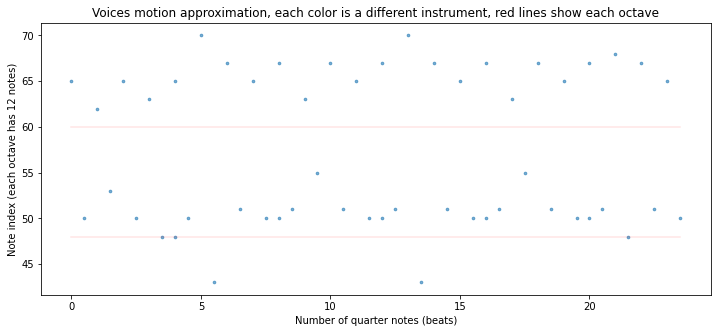

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)

    return ret, parent_element


def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0

    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue

        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)

        aux = min(y)
        if (aux < minPitch): minPitch = aux

        aux = max(y)
        if (aux > maxPitch): maxPitch = aux

        aux = max(x)
        if (aux > xMax): xMax = aux

    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()


# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

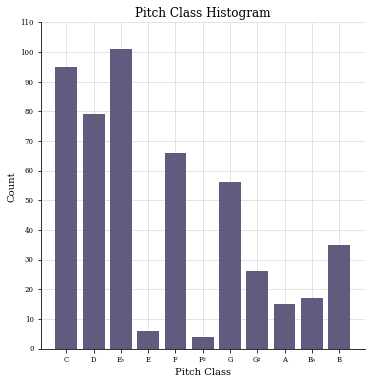

In [5]:
base_midi.plot('histogram', 'pitchClass', 'count')

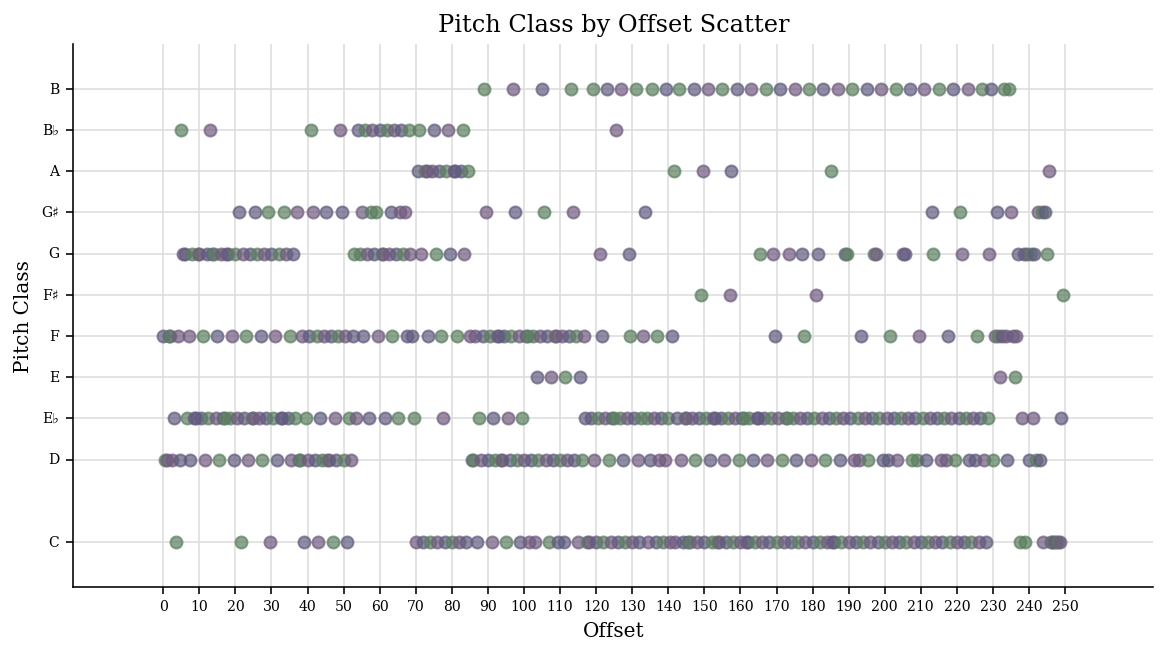

In [6]:
base_midi.plot('scatter', 'offset', 'pitchClass')

In [7]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: c minor
Music key confidence: 0.9033138539363545
Other music key alternatives:
B- major


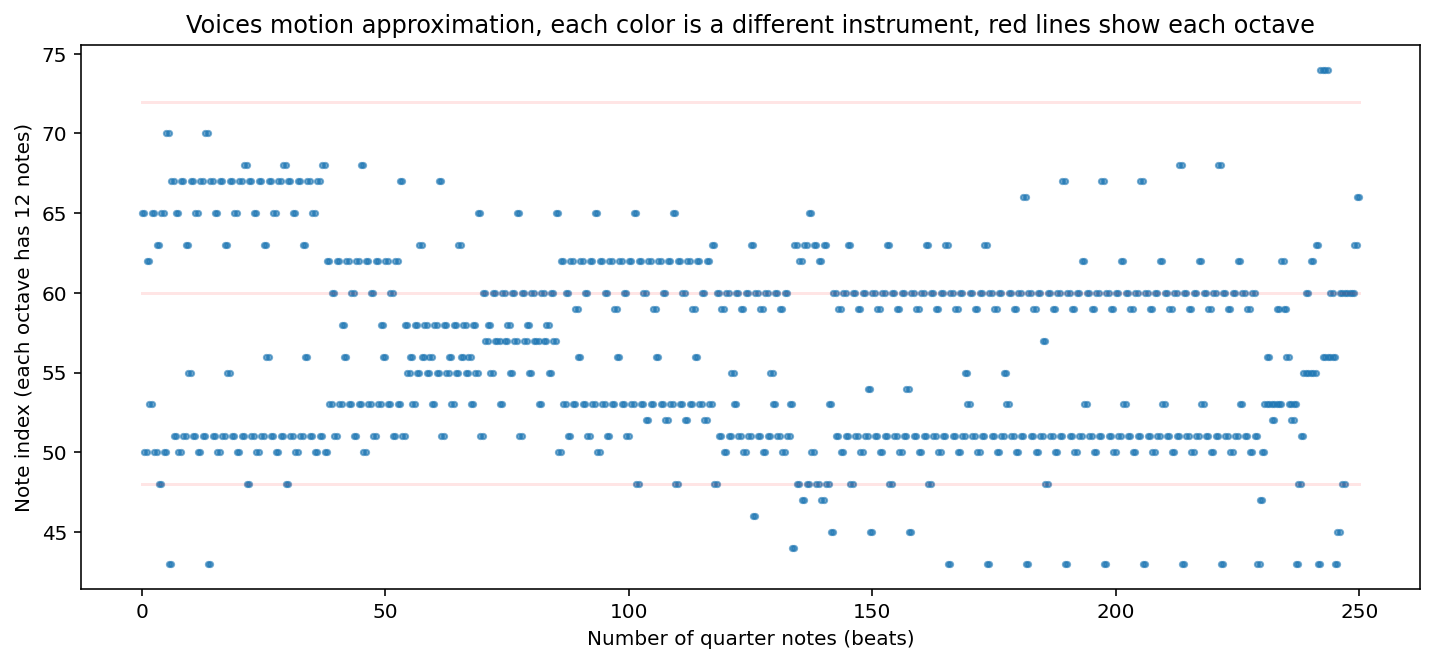

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Instrument ''>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord F4>
    {0.5} <music21.chord.Chord D3 F4>
    {1.0} <music21.chord.Chord D3 D4>
    {1.5} <music21.chord.Chord F3 D4>
    {2.0} <music21.chord.Chord F3 F4>
    {2.5} <music21.chord.Chord D3 F4>
    {3.0} <music21.chord.Chord D3 E-4>
    {3.5} <music21.chord.Chord C3 E-4>


In [8]:
from music21 import stream

temp_midi_chords = open_midi("../test_output_567_epoch.mid", True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")
